# Opdracht Sessie 04 -  Natural Language Processing

Sinds enkele jaren schieten de Natural Language Processing toepassingen als paddenstoelen uit de grond. Eén van de belangrijkste redenen daarvoor is de steeds groter wordende beschikbaarheid van tekstuele data aangeleverd door bijvoorbeeld social media.

In deze opdracht zal NLP toegepast worden in het kader van sentiment analysis. De bedoeling van sentiment analysis is om uit een tekstueel bericht zoals een email, sms, twitter bericht, Trip Advisor review het sentiment te voorspellen. Bedrijven weten bijvoorbeeld graag wat het sentiment is in de berichten die online over hen verschijnen.

De opdracht bestaat uit 2 deelopdrachten.

De eerste deelopdracht gaat rond het uitvoeren van pure sentiment analysis van Tweets.
Bij de tweede deelopdracht is het de bedoeling om cyber trolls op te sporen.

Telkens wordt het bag-of-words model gebruikt om tekst voor te stellen en vervolgens worden verschillende classifiers getraind om het sentiment/rating te voorspellen.

Het bag-of-words model beschrijft het voorkomen van woorden binnen een document en doet dit op bais van een vocabulair van gekende woorden en meet de aanwezigheid van deze gekende woorden. De grote beperking van het bag-of-words model is dat het enkel rekening houdt met welke woorden in een bericht voorkomen en niet met de volgorde ervan. Daardoor is het bag-of-words model heel beperkt in het capteren van de context waarin woorden in een bericht voorkomen . Tijdens de module deep learning zullen we afstappen van het bag-of-words model en gebruik maken van word embeddings in combinatie met LSTM neurale netwerken. Op deze manier kunnen we modellen trainen die wel rekening houden met de context en woordvolgordes.

In [41]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import sklearn.metrics as metrics

from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB

import nltk
import seaborn as sns
from nltk.corpus import stopwords
import re #regular expressions
from bs4 import BeautifulSoup
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

import time

pd.set_option('display.max_rows',1000)
pd.set_option('display.max_columns',1000)
pd.set_option('display.max_colwidth',150)

## Airline sentiment

De dataset 'Airlines_sentiment.csv' bevat tweets over verschillende airlines. Jouw taak bestaat erin om een classifier te trainen die zo goed mogelijk het sentiment van de tweets kan classificeren als positive, neutral en negative.
Het sentiment bevindt zich in de kolom 'airline_sentiment' en de tweet zelf in de kolom 'text'.
Doorloop de volgende stappen:
- Analyse van de data
- Preprocessing
- Training en hyperparameter tuning
- Modeloptimalisatie


In [159]:
# Inlezen van de dataset

dataset = pd.read_csv('Airline_sentiment.csv',encoding = 'ISO-8859-1')
dataset.tail()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,airline_sentiment,airline_sentiment:confidence,negativereason,negativereason:confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone
14635,681679794,False,finalized,3,2/25/15 19:46,positive,0.3487,NaN,0.0000,American,NaN,KristenReenders,NaN,0,@AmericanAir thank you we got on a different flight to Chicago.,NaN,2/22/15 12:01,5.695880e+17,NaN,NaN
14636,681679795,False,finalized,3,2/25/15 19:14,negative,1.0000,Customer Service Issue,1.0000,American,NaN,itsropes,NaN,0,@AmericanAir leaving over 20 minutes Late Flight. No warnings or communication until we were 15 minutes Late Flight. That's called shitty customer...,NaN,2/22/15 11:59,5.695870e+17,Texas,NaN
14637,681679796,False,finalized,3,2/25/15 19:04,neutral,1.0000,NaN,NaN,American,NaN,sanyabun,NaN,0,@AmericanAir Please bring American Airlines to #BlackBerry10,NaN,2/22/15 11:59,5.695870e+17,"Nigeria,lagos",NaN
14638,681679797,False,finalized,3,2/25/15 18:59,negative,1.0000,Customer Service Issue,0.6659,American,NaN,SraJackson,NaN,0,"@AmericanAir you have my money, you change my flight, and don't answer your phones! Any other suggestions so I can make my commitment??",NaN,2/22/15 11:59,5.695870e+17,New Jersey,Eastern Time (US & Canada)
14639,681679798,False,finalized,3,2/25/15 19:06,neutral,0.6771,NaN,0.0000,American,NaN,daviddtwu,NaN,0,@AmericanAir we have 8 ppl so we need 2 know how many seats are on the next flight. Plz put us on standby for 4 people on the next flight?,NaN,2/22/15 11:58,5.695870e+17,"dallas, TX",NaN


### Analyse van de dataset

- Onderzoek de gebalanceerdheid van de dataset. Stel grafisch de verdeling voor van het sentiment.
- Visualiseer de verdeling van het sentiment per airline. Maak daarvoor per airline een Seaborn countplot van het sentiment.
- Welke airline lijkt op basis van deze tweet het best te scoren en welke het slechtst?
- Uit hoeveel woorden bestaat het langste twitter bericht en uit hoeveel woorden het kortste?

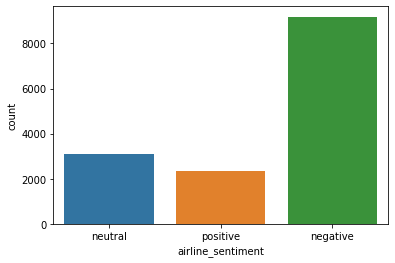

In [3]:
# Analyse van de dataset
sns.countplot(data=dataset, x='airline_sentiment')

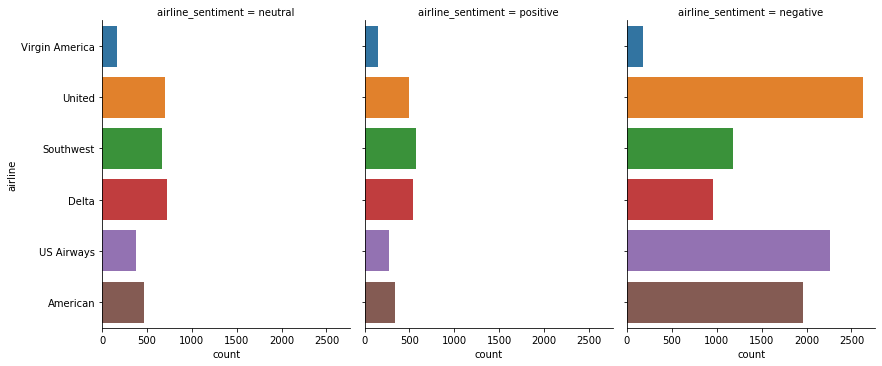

In [4]:
sns.catplot(y="airline", col="airline_sentiment", col_wrap=4,
                data=dataset,
                kind="count", height=5, aspect=.8)

In [5]:
# positivity rate per airline
for airline in dataset.airline.unique():
    # 0 -> negative
    # 1 -> neutral
    # 2 -> positive
    airline_sentiments = dataset[dataset.airline == airline].groupby('airline_sentiment').count()['_unit_id'].unique()
    positivity_rate = airline_sentiments[2] / airline_sentiments[0]
    print(airline, f'-> positive: {airline_sentiments[2]}, negative: {airline_sentiments[0]}, rate ->', positivity_rate)

Virgin America -> positive: 152, negative: 181, rate -> 0.8397790055248618
United -> positive: 492, negative: 2633, rate -> 0.1868590960881124
Southwest -> positive: 570, negative: 1186, rate -> 0.4806070826306914
Delta -> positive: 544, negative: 955, rate -> 0.5696335078534032
US Airways -> positive: 269, negative: 2263, rate -> 0.11886875828546177
American -> positive: 336, negative: 1960, rate -> 0.17142857142857143


In [6]:
print('max -> ', dataset.text.map(len).max())
print('min -> ', dataset.text.map(len).min())

max ->  229
min ->  12


#### Analyse
De best scorende maatschappij is **Virgin America**. De verhouding tussen positieve en negatieve berichten is hier het best.
De slechts scorende maatschappij is **US Airways**. De verhouding tussen positieve en negatieve berichten is hier het slechts. 

De langeste tweet is 229 karakters en de kortste is er 12

### Preprocessing

Onderzoek of er mogelijks foutieve of ontbrekende data aanwezig is. 
Kuis de tweets op: verwijder stopwoorden en niet-letters, zet alles om naar lowercase en pas stemming toe.
Maak gebruik van de CountVectorizer en TfidfTransformer om een bag-of-words model te creëren. 

Meer info: 

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html 

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html#sklearn.feature_extraction.text.TfidfTransformer 

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer

Splits op in een training set en test set. Zorg ervoor dat er 3000 tweets in de test set steken.


In [160]:
targets = dataset.airline_sentiment.values
features = dataset.text.values

In [174]:
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=3000, random_state=123)

In [162]:
def text_processing(text, language = 'english', min_word_size = 2):
    # remove html
    text_no_html = BeautifulSoup(str(text),"html.parser" ).get_text()
    
    # remove non-letters
    text_alpha_chars = re.sub("[^a-zA-Z']", " ", str(text_no_html)) 
        
    # convert to lower-case
    text_lower = text_alpha_chars.lower()
    
    # remove stop words
    stops = set(stopwords.words(language)) 
    text_no_stop_words = ' '
    
    for w in text_lower.split():
        if w not in stops:  
            text_no_stop_words = text_no_stop_words + w + ' '
      
       # do stemming
    text_stemmer = ' '
    stemmer = SnowballStemmer(language)
    for w in text_no_stop_words.split():
        text_stemmer = text_stemmer + stemmer.stem(w) + ' '
         
    # remove short words
    text_no_short_words = ' '
    for w in text_stemmer.split(): 
        if len(w) >= min_word_size:
            text_no_short_words = text_no_short_words + w + ' '
 

    return text_no_short_words

In [175]:
X_train = list(map(lambda text: text_processing(text), X_train))
X_test = list(map(lambda text: text_processing(text), X_test))

In [176]:
count_vector = CountVectorizer()
count_vector.fit(X_train)
X_train_bag = count_vector.transform(X_train)
X_test_bag = count_vector.transform(X_test)

In [177]:
transformer = TfidfTransformer(use_idf=True)
transformer.fit(X_train_bag)
X_train_bag_tf = transformer.transform(X_train_bag)
X_test_bag_tf = transformer.transform(X_test_bag)

In [178]:
print(X_train_bag_tf.shape)
print(y_train.shape)

(11640, 9463)
(11640,)


In [167]:
# Trainen van de classifiers (naive bayes, logistic regression, SVM)
start_time = time.process_time()
naive_baye = MultinomialNB(alpha=0.15)
naive_baye.fit(X_train_bag_tf, y_train)
print('Training took: ', time.process_time() - start_time)

y_pred_nb = naive_baye.predict(X_test_bag_tf)

print('classification report: \n', classification_report(y_test, y_pred_nb))
print('confussion matrix: \n', confusion_matrix(y_test, y_pred_nb))
print('f1 score:', metrics.f1_score(y_test, y_pred_nb, average='micro'))

Training took:  0.024755456000093545
classification report: 
               precision    recall  f1-score   support

    negative       0.75      0.97      0.85      1898
     neutral       0.70      0.32      0.44       649
    positive       0.76      0.42      0.54       453

    accuracy                           0.75      3000
   macro avg       0.74      0.57      0.61      3000
weighted avg       0.74      0.75      0.71      3000

confussion matrix: 
 [[1840   44   14]
 [ 398  206   45]
 [ 216   46  191]]
f1 score: 0.7456666666666667


In [16]:
from skopt import BayesSearchCV #scikit-optimize
parameters = {
    'alpha': (0.01, 1, 'uniform')
}

bayes_search = BayesSearchCV(MultinomialNB(),parameters,n_iter=20,cv=5,verbose=1,n_jobs=-1)
bayes_search.fit(X_train_bag_tf, y_train)

print('best parameters ->', bayes_search.best_params_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/florian/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished
/home/florian/.local/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:400: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished
/home/florian/.local/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:400: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished
/home/florian/.local/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:400: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished
/home/florian/.local/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:400: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


best parameters -> {'alpha': 0.15242747880668034}


In [20]:
y_pred_bs = bayes_search.predict(X_test_bag_tf)

print('classification report: \n', classification_report(y_test, y_pred_bs))
print('confussion matrix: \n', confusion_matrix(y_test, y_pred_bs))
print('f1 score:', metrics.f1_score(y_test, y_pred_bs, average='micro'))

classification report: 
               precision    recall  f1-score   support

    negative       0.75      0.97      0.84      1882
     neutral       0.72      0.33      0.45       655
    positive       0.80      0.45      0.58       463

    accuracy                           0.75      3000
   macro avg       0.76      0.58      0.62      3000
weighted avg       0.75      0.75      0.72      3000

confussion matrix: 
 [[1825   38   19]
 [ 410  213   32]
 [ 209   46  208]]
f1 score: 0.7486666666666668


In [181]:
start_time = time.process_time_ns()
log_reg = LogisticRegression(C=1, class_weight='balanced', max_iter=500)
params = {
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'C': (0.01, 100, 'uniform')
}

bayes_search = BayesSearchCV(log_reg,params,n_iter=50,cv=5,n_jobs=-1)
bayes_search = bayes_search.fit(X_train_bag_tf, y_train)
print('Training took: ', (time.process_time_ns() - start_time) * 10**-9)

log_reg = bayes_search.best_estimator_
print('Best parameters -> ', bayes_search.best_params_)

y_pred_log = log_reg.predict(X_test_bag_tf)
print('classification report: \n', classification_report(y_test, y_pred_log))
print('confussion matrix: \n', confusion_matrix(y_test, y_pred_log))
print('f1 score:', metrics.f1_score(y_test, y_pred_log, average='micro'))

/home/florian/.local/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:400: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/florian/.local/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:400: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Training took:  562.168568962
Best parameters ->  {'C': 11.826849554711986, 'solver': 'liblinear'}
classification report: 
               precision    recall  f1-score   support

    negative       0.87      0.86      0.86      1882
     neutral       0.63      0.62      0.63       655
    positive       0.71      0.75      0.73       463

    accuracy                           0.79      3000
   macro avg       0.74      0.74      0.74      3000
weighted avg       0.79      0.79      0.79      3000

confussion matrix: 
 [[1624  175   83]
 [ 192  407   56]
 [  57   61  345]]
f1 score: 0.792


In [226]:
start_time = time.process_time_ns()
log_reg_best = LogisticRegression(C=1.20, solver='liblinear', class_weight='balanced')
log_reg_best = log_reg_best.fit(X_train_bag_tf, y_train)
print('Training took: ', (time.process_time_ns() - start_time) * 10**-9)

y_preds = log_reg_best.predict(X_test_bag_tf)

print('classification report: \n', classification_report(y_test, y_preds))
print('confussion matrix: \n', confusion_matrix(y_test, y_preds))
print('f1 score:', metrics.f1_score(y_test, y_preds, average='micro'))

ValueError: Found input variables with inconsistent numbers of samples: [21888, 11640]

In [48]:
start_time = time.process_time_ns()
svmc = svm.SVC()
params = {
    'kernel': ['linear', 'rbf'],
    'gamma': (0.01, 100, 'uniform'),
    'class_weight': ['balanced', None]
}

bayes_search = BayesSearchCV(svmc,params,n_iter=50,cv=5,n_jobs=-1)
bayes_search = bayes_search.fit(X_train_bag_tf, y_train)
print('Training took: ', (time.process_time_ns() - start_time) * 10**-9)

svmc = bayes_search.best_estimator_
print('best params -> ', bayes_search.best_params_)



/home/florian/.local/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:400: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/florian/.local/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:400: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/florian/.local/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:400: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/florian/.local/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:400: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/florian/.local/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:400: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has be

Training took:  488.67318855800005
best params ->  {'class_weight': None, 'gamma': 27.759432648447916, 'kernel': 'linear'}


In [49]:
y_preds = svmc.predict(X_test_bag_tf)

print('classification report: \n', classification_report(y_test, y_preds))
print('confussion matrix: \n', confusion_matrix(y_test, y_preds))
print('f1 score:', metrics.f1_score(y_test, y_preds, average='micro'))

classification report: 
               precision    recall  f1-score   support

    negative       0.83      0.92      0.88      1882
     neutral       0.70      0.54      0.61       655
    positive       0.80      0.70      0.75       463

    accuracy                           0.81      3000
   macro avg       0.78      0.72      0.75      3000
weighted avg       0.80      0.81      0.80      3000

confussion matrix: 
 [[1738   96   48]
 [ 268  355   32]
 [  83   55  325]]
f1 score: 0.806


In [52]:
start_time = time.process_time_ns()
svmc_best = svm.SVC(kernel='linear')
svmc_best = svmc_best.fit(X_train_bag_tf, y_train)
print('Training took: ', (time.process_time_ns() - start_time) * 10**-9)

y_preds = svmc_best.predict(X_test_bag_tf)

print('classification report: \n', classification_report(y_test, y_preds))
print('confussion matrix: \n', confusion_matrix(y_test, y_preds))
print('f1 score:', metrics.f1_score(y_test, y_preds, average='micro'))

Training took:  7.310985469
classification report: 
               precision    recall  f1-score   support

    negative       0.83      0.92      0.88      1882
     neutral       0.70      0.54      0.61       655
    positive       0.80      0.70      0.75       463

    accuracy                           0.81      3000
   macro avg       0.78      0.72      0.75      3000
weighted avg       0.80      0.81      0.80      3000

confussion matrix: 
 [[1738   96   48]
 [ 268  355   32]
 [  83   55  325]]
f1 score: 0.806


Welke classifier heeft jouw voorkeur? Beargumenteer in termen van accuracy, f1-score maar ook de berekeningstijd.


### Antwoord

Alle classifiers hebben last van de ongebalanceerde data.  
**Naive Bayes** traint het snelst, maar behaald ook de laagste F1-scores (74%). Die heeft voornamelijk moeite met **recall** van de verschillende klasses.  
**Logistic Regression** traint net iets trager dan Naive Bayes, maar traint nog steeds zeer snel. Dit model behaalt ook de beste F1-score(80.8%).  
**SVM** traint het traagst van allemaal, maar behaalt ook een goede F1-score (80.6%).  

Mijn voorkeur gaat naar **Logistic Regression**. Dit model traint zeer snel en behaalt de beste F1-score. De recall van dit model ligt ook hoger dan dat van **SVM** 

### Modeloptimalisatie

- Stel dat de airlines vooral geïnteresseerd zijn in het correct opsporen van negatieve tweets. Welke aanpassingen zou je kunnen doen om ervoor te zorgen dat het model minder negatieve tweets verkeerd classificeert? Test deze aanpassingen.

- Bekom je een beter model met een hogere accuraatheid wanneer je ook de feature airline in rekening brengt? Een optie hierbij is ook om voor elke airline een apart model te trainen. 

- Bekom je een beter model wanneer je de lengte van de tweets in rekening brengt?

In [183]:
# Modeloptimalisatie
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=5)
X_train_bag_tf, y_train = sm.fit_resample(X_train_bag_tf, y_train)

In [184]:
start_time = time.process_time_ns()
log_reg_best = LogisticRegression(C=1.2, solver='liblinear')
log_reg_best = log_reg_best.fit(X_train_bag_tf, y_train)
print('Training took: ', (time.process_time_ns() - start_time) * 10**-9)

y_preds = log_reg_best.predict(X_test_bag_tf)

print('classification report: \n', classification_report(y_test, y_preds))
print('confussion matrix: \n', confusion_matrix(y_test, y_preds))
print('f1 score:', metrics.f1_score(y_test, y_preds, average='micro'))

Training took:  0.210001402
classification report: 
               precision    recall  f1-score   support

    negative       0.89      0.83      0.86      1882
     neutral       0.60      0.69      0.64       655
    positive       0.71      0.77      0.74       463

    accuracy                           0.79      3000
   macro avg       0.74      0.76      0.75      3000
weighted avg       0.80      0.79      0.79      3000

confussion matrix: 
 [[1558  237   87]
 [ 147  453   55]
 [  45   63  355]]
f1 score: 0.7886666666666666


In [332]:
features = dataset.text
X_train, X_test, y_train, y_test = train_test_split(features, targets, random_state=123, test_size=3000)

X_train = X_train.apply(text_processing)
X_test= X_test.apply(text_processing)

In [271]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer

def get_airline(value):
    idx = value.index
    airlines = []
    for i in idx:
        airlines.append(dataset['airline'].iloc[i])
    tmp_dataframe = pd.DataFrame(data={'airline': airlines})
    tmp_dataframe = pd.get_dummies(data=tmp_dataframe)
    return tmp_dataframe

params = {
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'C': (0.01, 100, 'uniform')
}

# params = {
#     'alpha': (0.1, 100, 'uniform')
# }

# params = {
#     'kernel': ['linear', 'rbf'],
#     'gamma': (0.01, 100, 'uniform'),
#     'class_weight': ['balanced', None]
# }

classifier = Pipeline([
    ('features', FeatureUnion([
        ('text', Pipeline([
            ('vectorizer', CountVectorizer()),
            ('tdif', TfidfTransformer(use_idf=True))
        ])),
        ('airline', Pipeline([
            ('count', FunctionTransformer(get_airline, validate=False))
        ]))
    ])),
    ('Logistic', BayesSearchCV(LogisticRegression(), params, scoring='f1_micro', cv=3, n_iter=20))
])

classifier.fit(X_train, y_train)
y_preds = classifier.predict(X_test)

print('confussion_matrix \n', confusion_matrix(y_test, y_preds))
print('report \n', classification_report(y_test, y_preds))
print('f1', metrics.f1_score(y_test, y_preds, average='micro'))

/home/florian/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/florian/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/florian/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/florian/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/florian/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The m

/home/florian/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/florian/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressi

confussion_matrix 
 [[1757   80   45]
 [ 272  354   29]
 [  86   56  321]]
report 
               precision    recall  f1-score   support

    negative       0.83      0.93      0.88      1882
     neutral       0.72      0.54      0.62       655
    positive       0.81      0.69      0.75       463

    accuracy                           0.81      3000
   macro avg       0.79      0.72      0.75      3000
weighted avg       0.80      0.81      0.80      3000

f1 0.8106666666666666


/home/florian/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [272]:
classifier['Logistic'].best_params_

{'C': 1.2287449885329151, 'solver': 'saga'}

##  Cyber trolls

Een cyber troll heeft als bedoeling emotionele reacties uit te lokken door opzettelijk verkeerde, kwetsende en agressieve berichten te plaatsen op forums, newsgroups, social media, etc. Online platformen hebben er een groot belang bij om deze cyber trolls te kunnen detecteren en weren van hun platform. Daarvoor gebruiken ze geavanceerde nlp algoritmes. Ontwerp zelf een cyber troll detector op basis. Je kan daarvoor beroep doen op de dataset 'Cybetrolls.csv'. Om de dataset te evalueren gebruik je een test set van 5000 berichten.

Welke woorden worden het meest door cyber trolls gebruikt? Geef een top 10.

Voor het evalueren van de classifier gebruik je de volgende metrics: accuracy, f1 score en de ROC. Formuleer conclusies. Bijvoorbeeld naar de keuze toe van de classifier, interpretatie van de ROC of auROC. Toon enkele verkeerd geclassificeerde berichten en probeer te achterhalen waarom ze verkeerd geclassificeerd werden.


In [4]:
dataset = pd.read_csv('Cybetrolls.csv')
dataset.head()

,annotation,content
0,1,Get fucking real dude.
1,1,She is as dirty as they come and that crook Rengel the Dems are so fucking corrupt it's a joke. Make Republicans look like ...
2,1,why did you fuck it up. I could do it all day too. Let's do it when you have an hour. Ping me later to sched writing a book here.
3,1,Dude they dont finish enclosing the fucking showers. I hate half assed jobs. Whats the reasononing behind it? Makes no sense.
4,1,WTF are you talking about Men? No men thats not a menage that's just gay.
